In [1]:
import findspark
findspark.init('C:\\spark\\spark-2.3.1-bin-hadoop2.7')

In [2]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import stddev, avg, broadcast, max
from datetime import datetime
from pyspark.sql.functions import col, split
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml import PipelineModel, Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer, MinMaxScaler, OneHotEncoder, HashingTF, IDF
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

spark = SparkSession.builder.appName('useful_model').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.3' # make sure we have Spark 2.3+

from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Collecting data
data = spark.read.parquet('MLearnBinary/train')
data = data.cache()
data.columns

['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'fans',
 'review_count',
 'useful',
 'review_useful_votes',
 'friends_count',
 'reviewtext_count',
 'no_months',
 'useful_category']

<b>predictors and target:</b><br>
'average_stars' - average stars the user has received<br>
'compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list','compliment_more','compliment_note',<br>
'compliment_photos','compliment_plain','compliment_profile','compliment_writer' - compiments received by the user<br>
'fans' - number of fans the user has<br>
'review_count' - number of reviews given by the user<br>
'useful' - count of user's useful votes<br>
'review_useful_votes' - useful votes for a review<br>
'friends_count' - number of friends the user has<br>
'reviewtext_count' - length of the review text<br>
'no_months' - yelping period in months<br>
'useful_category' - usefulness category to be predicted<br>

In [4]:
#checking data for each class
class_count = data.groupby("useful_category").count().orderBy('count', ascending=False).cache()
class_count.show()

+---------------+-------+
|useful_category|  count|
+---------------+-------+
|     not_useful|2537521|
|         useful|2260211|
+---------------+-------+



In [5]:
# Finding min count
min_count = class_count.agg({"count": "min"}).collect()[0][0]
category_list = class_count.select("useful_category").rdd.flatMap(lambda x: x).collect()
category_count_list = class_count.select("count").rdd.flatMap(lambda x: x).collect()

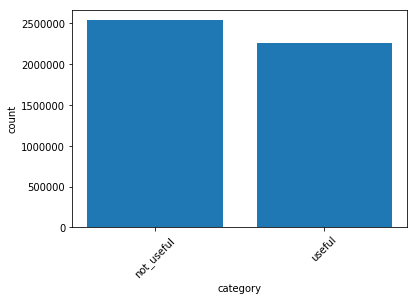

In [6]:
# Plot class count
plt.bar(category_list,category_count_list)
plt.xticks(rotation=45)
plt.xlabel('category')
plt.ylabel('count')
plt.show()

In [7]:
#total count of train data
class_count.unpersist()
train_data_model,validation = data.randomSplit([0.9, 0.1],seed=1234) 
train_data_model = train_data_model.cache()
validation = validation.cache()
train_data_model.count()

4318977

Model Logistic Regression:

In [8]:
req_columns = ['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'fans',
 'review_count',
 'useful',
 'friends_count',
 'reviewtext_count',
 'no_months']

vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
logit_reg = LogisticRegression(featuresCol="scaledFeatures", labelCol="label",maxIter=100, regParam=0.3, elasticNetParam=0.0)

In [9]:
useful_pipeline = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,logit_reg])

useful_model = useful_pipeline.fit(train_data_model)
useful_predictions = useful_model.transform(validation)
evaluator = BinaryClassificationEvaluator()
score = evaluator.evaluate(useful_predictions)
print('Validation score for model using LogisticRegression: %g' % (score))

Validation score for model using LogisticRegression: 0.706794


Other Models:

In [10]:
# Using Decision Tree Classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
dtc = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label")
useful_pipeline_dtc = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,dtc])
useful_model_dtc = useful_pipeline_dtc.fit(train_data_model)
useful_predictions_dtc = useful_model_dtc.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")
score_dtc = evaluator.evaluate(useful_predictions_dtc)
print('Validation score for model using Decision Tree Classifier: %g' % (score_dtc))

Validation score for model using Decision Tree Classifier: 0.662612


In [11]:
# Using Random Forest Classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures", numTrees=10)
useful_pipeline_rf = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,rf])
useful_model_rf = useful_pipeline_rf.fit(train_data_model)
useful_predictions_rf = useful_model_rf.transform(validation)
evaluator = BinaryClassificationEvaluator()
score_rf = evaluator.evaluate(useful_predictions_rf)
print('Validation score for model using Random Forest Classifier: %g' % (score_rf))

Validation score for model using Random Forest Classifier: 0.719302


In [12]:
# Using Naive Bayes Classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
NB = NaiveBayes(smoothing=1.0,featuresCol="scaledFeatures", labelCol="label")
useful_pipeline_NB = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,NB])
useful_model_NB = useful_pipeline_NB.fit(train_data_model)
useful_predictions_NB = useful_model_NB.transform(validation)
evaluator = BinaryClassificationEvaluator()
score_NB = evaluator.evaluate(useful_predictions_NB)
print('Validation score for model using Naive Bayes Classifier: %g' % (score_NB))

Validation score for model using Naive Bayes Classifier: 0.328312


In [13]:
#Using Multilayer perceptron classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
mlp = MultilayerPerceptronClassifier(featuresCol="scaledFeatures", labelCol="label",maxIter=5, layers=[18, 24, 24], blockSize=32, seed=1243)
useful_pipeline_mlp = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,mlp])
useful_model_mlp = useful_pipeline_mlp.fit(train_data_model)
useful_predictions_mlp = useful_model_mlp.transform(validation)
evaluator = BinaryClassificationEvaluator()
score_mlp = evaluator.evaluate(useful_predictions_mlp)
print('Validation score for model using Multilayer perceptron classifier: %g' % (score_mlp))

Validation score for model using Multilayer perceptron classifier: 0.44229


In [14]:
# Using Gradient Boosting Tree Classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
gbt = GBTClassifier(labelCol="label", featuresCol="scaledFeatures", maxIter=5)
useful_pipeline_gbt = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,gbt])
useful_model_gbt = useful_pipeline_gbt.fit(train_data_model)
useful_predictions_gbt = useful_model_gbt.transform(validation)
evaluator = BinaryClassificationEvaluator()
score_gbt = evaluator.evaluate(useful_predictions_gbt)
print('Validation score for model using Random Forest Classifier: %g' % (score_gbt))

Validation score for model using Random Forest Classifier: 0.725348


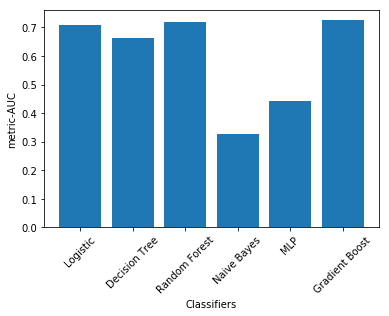

[0.7067939087756936, 0.662612400914873, 0.7193020021539658, 0.3283117108469618, 0.4422901173802699, 0.7253476807465463]


In [15]:
# Plotting Accuracies
plt.bar(["Logistic","Decision Tree","Random Forest","Naive Bayes","MLP","Gradient Boost"],\
        [score,score_dtc,score_rf,score_NB,score_mlp,score_gbt])
plt.xticks(rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('metric-AUC')
plt.show()
scores_list = [score,score_dtc,score_rf,score_NB,score_mlp,score_gbt]
print(scores_list)

In [16]:
# GBT Classifier is the best
# Saving model with best accuracy
useful_model_gbt.write().overwrite().save("Model_Useful_Binary")

In [3]:
# Loading model
load_model = PipelineModel.load("Model_Useful_Binary")
test_data = spark.read.parquet("MLearnBinary/test")
predictions_test = load_model.transform(test_data)
predictions_test = predictions_test.orderBy("label")
evaluator_test = BinaryClassificationEvaluator()
score_test = evaluator_test.evaluate(predictions_test)
print('Test score for model: %g' % (score_test))

Test score for model: 0.727331


In [17]:
# Precision
precision_score(y_true, y_pred)

0.682701386044707

In [18]:
# Recall
recall_score(y_true, y_pred)

0.5605512202633269

In [4]:
# Confusion matrix
from sklearn.metrics import confusion_matrix,precision_score,recall_score

y_true = predictions_test.select("label")
y_true = y_true.toPandas()

y_pred = predictions_test.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[487065, 147198],
       [248289, 316712]], dtype=int64)

In [5]:
# prediction labels
predictions_test.groupby("useful_category","label").count().show()

+---------------+-----+------+
|useful_category|label| count|
+---------------+-----+------+
|     not_useful|  0.0|634263|
|         useful|  1.0|565001|
+---------------+-----+------+



Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

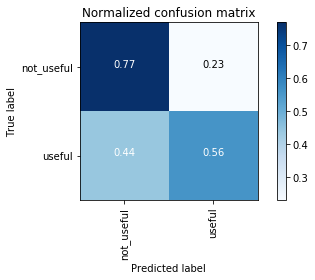

<Figure size 432x288 with 0 Axes>

In [6]:
from sklearn.metrics import confusion_matrix
import itertools
'''
plot_confusion_matrix taken from
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#sphx-glr-download-auto-examples-model-selection-plot-confusion-matrix-py
'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
class_list = ["not_useful","useful"]
plot_confusion_matrix(cnf_matrix, classes=class_list, normalize=True, title='Normalized confusion matrix')
plt.figure()

In [7]:
print('Test score for model: %g' % (score_test))

Test score for model: 0.727331


<b>Categories</b> - <br>
"not_useful" - 0 useful votes<br>
"useful" - more than 0 useful votes 
<br>
Test score for model: 0.727331
<br>
Achieved <b>72%</b> accuracy on the model